## Generative pretrained image priors for MRI reconstruction
**Creator**: [Guanxiong Luo](https://ggluo.github.io)

**Overview**:
This notebook is to present how to use the pretrained image priors to improve MR reconstruction. What we will use here are the following:
1. a library for generative image prior, called [spreco](https://pypi.org/project/spreco),
2. a MR image reconstruction toolbox, called [BART](https://www.github.com/mrirecon/bart),
3. several pretrained models hosted on this huggingface [page](https://huggingface.co/Guanxiong/MRI-Image-Priors).
4. TensorFlow C API


#### Let's get all of them at first!

In [ ]:
%%bash
git clone https://github.com/ggluo/spreco
cd spreco
git checkout devel
pip install .
pip install huggingface_hub

wget -q https://storage.googleapis.com/tensorflow/libtensorflow/libtensorflow-gpu-linux-x86_64-2.12.0.tar.gz
mkdir tensorflow && tar -C tensorflow -xvzf libtensorflow-gpu-linux-x86_64-2.12.0.tar.gz

wget -q https://raw.githubusercontent.com/ggluo/image-priors/release/misc/kspace/mprage.hdr
wget -q https://raw.githubusercontent.com/ggluo/image-priors/release/misc/kspace/mprage.cfl

#### Prepare BART

%env LIBRARY_PATH=/content/tensorflow/include 
%env LD_LIBRARY_PATH=/content/tensorflow/lib
%env TF_CPP_MIN_LOG_LEVEL=3

In [ ]:
%%bash

# Install BARTs dependencies
apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev &> /dev/null

# Download BART version
[ -d /content/bart ] && rm -r /content/bart
git clone https://github.com/mrirecon/bart/ bart
[ -d "bart" ] && echo "BART was downloaded successfully."

COMPILE_SPECS=" PARALLEL=1
                TENSORFLOW=1
                TENSORFLOW_BASE=../tensorflow/"

printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local

cd bart
make &> /dev/null

In [ ]:
%env TOOLBOX_PATH=/content/bart

#### Download models and export the model for BART

In [1]:
from huggingface_hub import hf_hub_download

smld = ["config.yaml", "smld.data-00000-of-00001", "smld.index", "smld.meta"]
cplx_large = ["config.yaml", "pixelcnn.data-00000-of-00001", "pixelcnn.index", "pixelcnn.meta"]

for file in smld:
    hf_hub_download(repo_id="Guanxiong/MRI-Image-Priors", subfolder="Diffusion/SMLD", filename=file, local_dir="./")

for file in cplx_large:
    hf_hub_download(repo_id="Guanxiong/MRI-Image-Priors", subfolder="PixelCNN/cplx_large", filename=file, local_dir="./")

/home/gluo/anaconda3/envs/tf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
from spreco.exporter import exporter
from spreco.common import utils
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

import numpy as np

e = exporter("./PixelCNN/cplx_large", "pixelcnn", default_out=False, path="./PixelCNN/exported", name="cplx_large")

type = '2DCPLX'

if type == '2DMAG':

    x = tf.placeholder(tf.float32, shape=[1, 256, 256, 2], name="input_0")

    x_cplx = tf.complex(x[..., 0], x[..., 1])
    x_mag  = tf.abs(x_cplx)[..., tf.newaxis]

    logits = e.model.eval(x_mag)
    loss   = e.model.loss_func(x_mag, logits) / np.log(2.0) / np.prod([1, 256, 256, 1])


if type == '2DCPLX':

    x = tf.placeholder(tf.float32, shape=[1, 256, 256, 2], name="input_0")

    logits = e.model.eval(x)
    loss   = e.model.loss_func(x, logits) / np.log(2.0) / np.prod([1, 256, 256, 2])


e.export([x], [loss], attach_gradients=True)

2023-07-17 11:12:07.783570: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 11:12:08.581436: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO -> Exporting PIXELCNN model
INFO -> Customizing tf inputs and outputs


2023-07-17 11:12:12.832812: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-07-17 11:12:12.832864: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: fourier
2023-07-17 11:12:12.832875: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: fourier
2023-07-17 11:12:12.833042: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 460.91.3
2023-07-17 11:12:12.833079: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 460.91.3
2023-07-17 11:12:12.833090: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 460.91.3
2023-07-17 11:12:12.909746: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enable

INFO:tensorflow:Restoring parameters from ./PixelCNN/cplx_large/pixelcnn


#### Perform reconstruction

The below cell includes the following steps
1. create undersampling pattern
2. estimate coil sensitivities
3. compute reference and 
4. reconstruct image with l2-regularization and l1-regularzation in wavelet domain
5. reconstruct image with log-likelihood regularization by a generative prior

In [7]:
%%bash

nx=256
ny=256
cal=15
fx=3
fy=2

kspace=./kspace/mprage
graph=./PixelCNN/exported/cplx_large

# create undersampling pattern
bart upat -Y$nx -Z $ny -y $fx -z$fy -c$cal mask
bart transpose 0 1 mask mask
bart transpose 1 2 mask mask
bart fmac mask $kspace und_kspace

# estimate coil sensitivities
bart ecalib -r20 -m1 -c0.001 und_kspace coilsen

# compute reference
bart fft -i 3 $kspace coilimgs
bart fmac -C -s$(bart bitmask 3) coilimgs coilsen grd

# compute zero-filled
bart fft -i 3 und_kspace coilimgs
bart fmac -C -s$(bart bitmask 3) coilimgs coilsen zero_filled

# l2-regularized reconstruction
bart pics -l2 -r 0.01 und_kspace coilsen l2_pics

# l1-regularzied in wavelet domains reconstruction 
bart pics -l1 -r 0.01 und_kspace coilsen l1_pics

# log-likelihood regularized by a generative prior reconstruction
bart pics -i100 -d4 -R TF:{$graph}:0.8 und_kspace coilsen prior_pics

points: 8003, grid size: 256x256 = 65536 (R = 8.188930)
Done.
Size: 65536 Samples: 8002 Acc: 8.19
l2 regularization: 0.010000
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 0.978347
Size: 65536 Samples: 8002 Acc: 8.19
l1-wavelet regularization: 0.010000
Regularization terms: 1, Supporting variables: 0
FISTA
Total Time: 1.704662
Size: 65536 Samples: 8002 Acc: 8.19
Calibration region...  (size: 30x30x1, pos: 113x113x0)
Scaling: 601.256348  (max = 1247.702271/p90 = 601.256348/median = 123.161049)
Inverse scaling of the data: 601.256348
TensorFlow Loss: 0.800000 ./PixelCNN/exported/cplx_large
TensorFlow graph loaded from file ./PixelCNN/exported/cplx_large.pb.


2023-07-17 11:20:37.129384: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


TensorFlow session created.
TensorFlow session restored from path ./PixelCNN/exported/cplx_large.
Succesfully loaded TensorFlow v1 graph!
TensorFlow input mapping: grad_ys_0 grad_ys_0 0 REAL
TensorFlow input mapping: grad_0_0 grad_0_0 0 COMPLEX
TensorFlow input mapping: input_0 input_0 0 COMPLEX
TensorFlow input mapping: output_0 truediv_1 0 REAL
TensorFlow: Processed argument output_0 with dimensions: [  1 ]
TensorFlow: Processed argument grad_ys_0 with dimensions: [  1 ]
TensorFlow: Processed argument input_0 with dimensions: [256 256   1 ]
TensorFlow: Processed argument grad_0_0 with dimensions: [256 256   1 ]
Regularization terms: 1, Supporting variables: 0
FISTA
Loss: 0.180451
Loss: 1.546945
Loss: 1.654933
Loss: 1.675356
Loss: 1.624568
Loss: 1.533889
Loss: 1.424346
Loss: 1.312297
Loss: 1.209401
Loss: 1.118433
Loss: 1.039108
Loss: 0.974657
Loss: 0.926018
Loss: 0.892589
Loss: 0.867860
Loss: 0.849729
Loss: 0.836481
Loss: 0.827092
Loss: 0.819962
Loss: 0.817035
Loss: 0.814269
Loss: 0.8

#### Display the reconstruction

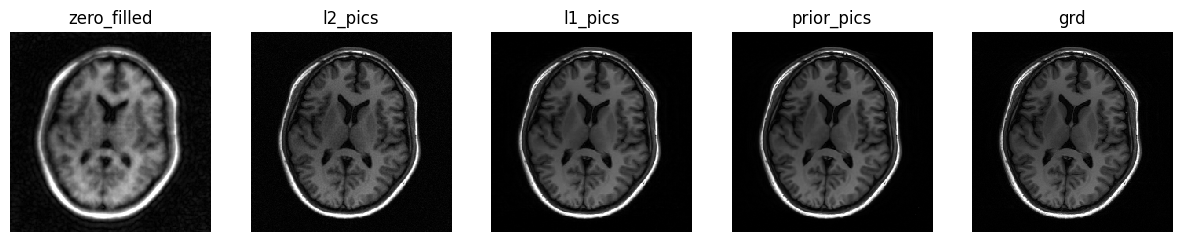

In [31]:
#### Create a function to plot the grid of images

%matplotlib inline
import matplotlib.pyplot as plt
from functools import partial

def subplot(ax, img, title, cmap, interpolation, vmin, vmax):
    ax.imshow(img, cmap=cmap, interpolation=interpolation, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')

plot_params = {'cmap': 'gray', 'interpolation': 'none', 'vmin': 0}
axplot      = partial(subplot, **plot_params)

recos = {"zero_filled": abs(utils.readcfl("zero_filled")), 
         "l2_pics": abs(utils.readcfl("l2_pics")),
         "l1_pics": abs(utils.readcfl("l1_pics")),
         "prior_pics": abs(utils.readcfl("prior_pics")),
         "grd": abs(utils.readcfl("grd"))
        }

grid_x=1
grid_y=5

fig, axss = plt.subplots(grid_x, grid_y, figsize=(15, 15), gridspec_kw={'width_ratios': [1  for _ in range(grid_y)]})
for j, key in enumerate(recos.keys()):
    axplot(axss[j], recos[key], title=key, vmax=0.7*np.max(recos[key]))

#### Generate MR images with the downloaded model
The cell below will take much longer than the above as the generation needs many iterations. Just let it go for around 20mins with a T4 accelerator on Colab, then come back. You will get 25 brain images that have a size of (256,256).

In [ ]:
from spreco.sampler import sampler
import numpy as np

log_path   = './Diffusion/SMLD'
model_path = log_path+'/smld'
config     = utils.load_config(log_path+'/config.yaml')

N=100
sigma_type='quad'
target_snr=0.2
print("INFO -> sigma type: %s, sigma max: %.4f, simga min: %.4f, discrete steps: %d "%( sigma_type, config['sigma_max'], config['sigma_min'], N))

config['N'] = N
a_sampler = sampler(config, target_snr, sigma_type)
a_sampler.init_sampler(model_path, gpu_id='0')

#### Predictor-and-corrector sampling 

In [ ]:
%matplotlib inline
grid_x=5
grid_y=5
samples_n, samples  = a_sampler.pc_sampler(grid_x*grid_y, 3)

images = samples_n[-1]
images = np.abs(utils.float2cplx(images))

fig, axss = plt.subplots(grid_x, grid_y, figsize=(10, 10), gridspec_kw={'width_ratios': [1  for _ in range(grid_x)]})
for i in range(grid_x):
    for j in range(grid_y):
        if i==0:
            strs='x_%d'%j
        else:
            strs=''
        axplot(axss[i,j], images[i*grid_y+j], title=strs, vmax=np.max(images[i*grid_y+j]))
plt.tight_layout(pad=.1)

#### Ancestral sampling

In [ ]:
grid_x=5
grid_y=5
a_sampler.steps=3
samples_n, samples  = a_sampler.ancestral_sampler(grid_x*grid_y, 3)

images = samples[-1]
images = np.abs(utils.float2cplx(images))

fig, axss = plt.subplots(grid_x, grid_y, figsize=(10, 10), gridspec_kw={'width_ratios': [1  for _ in range(grid_x)]})
for i in range(grid_x):
    for j in range(grid_y):
        if i==0:
            strs='x_%d'%j
        else:
            strs=''
        axplot(axss[i,j], images[i*grid_y+j], title=strs, vmax=np.max(images[i*grid_y+j]))
plt.tight_layout(pad=.1)